Import all the library to load images

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import mediapipe as mp

import os
import sys

sys.setrecursionlimit(150000)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# make 256 if you want extra padding
square_length = 224

# False will crop with taller palm ROI and resized to a square
# True will crop in a square pattern and resize
is_original_ratio = True

input_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/'
output_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/'

#sample image
img = cv2.imread('/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/230_5.JPG', cv2.IMREAD_UNCHANGED)

I0000 00:00:1731662985.822701 7602414 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1731662985.844653 7605216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731662985.856922 7605216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Get sample image and show the sample image

dtype: uint8, shape: (1200, 1600, 3), min: 0, max: 240


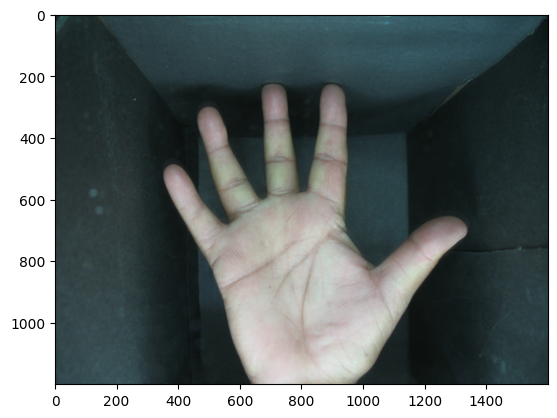

In [4]:
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)

Use Google's mediapipe to get hand landmarks.
This will eliminate bad images

In [5]:
# Process the image to detect hands
def show_hand(hand_data, hand_image):
    # Check if any hands were detected
    if hand_data.multi_hand_landmarks:
        for hand_landmarks in hand_data.multi_hand_landmarks:
            # Draw hand landmarks for visualization
            mp_drawing.draw_landmarks(hand_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    # Show the result
    plt.imshow(hand_image)

Create function to ro

In [6]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

Create function to use the hand landmark for rotate and get the palm ROI

In [7]:
def get_landmark_coordinates(hand_data, *landmark_names):
    if hand_data.multi_hand_landmarks is None:
        print(f"No landmarks in hand")
        return None
    try:
        hand_landmarks = hand_data.multi_hand_landmarks[0]
        return [hand_landmarks.landmark[name] for name in landmark_names]
    except IndexError as e:
        print("Some index is not valid:", e)
        return None

def calculate_rotation_angle(wrist, middle_finger_mcp):
    delta_x = wrist.x - middle_finger_mcp.x
    delta_y = wrist.y - middle_finger_mcp.y
    angle_rad = np.arctan2(delta_y, delta_x)
    return np.degrees(angle_rad) - 90

def process_image_rotation(image, angle):
    rotated_img = rotate_image(image, angle)
    return cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB), rotated_img.shape[:2]

def detect_hand_landmarks(image_data, rotated_rgb):
    return hands.process(rotated_rgb)

def calculate_square_dimensions(hand_data, image_dims):
    image_height, image_width = image_dims #image_size

    #find landmark
    landmarks = get_landmark_coordinates(hand_data,
                                         mp_hands.HandLandmark.INDEX_FINGER_MCP,
                                         mp_hands.HandLandmark.PINKY_MCP,
                                         mp_hands.HandLandmark.WRIST,
                                         mp_hands.HandLandmark.MIDDLE_FINGER_MCP)
    if not landmarks:
        return None, None, None, None
    index_finger_mcp, pinky_mcp, wrist, middle_finger_mcp = landmarks

    # find appropriate image length, length is the distance between index and pinky
    # this will make sure that the image is properly rotated first
    square_w = abs(int((index_finger_mcp.x - pinky_mcp.x) * image_width * 0.92))
    square_h = square_w # crop a square in the middle
    
    # allow taller palm ROI, get 92 height from wrist to middle finger
    if not is_original_ratio:
        square_h = abs(int((wrist.y - middle_finger_mcp.y) * image_height * 0.92))

    # center will be the middle of wrist and bottom middle finger
    center_x = int((wrist.y + middle_finger_mcp.x) / 2 * image_width)
    center_y = int((wrist.y + middle_finger_mcp.y) / 2 * image_height)
    return square_w, square_h, center_x, center_y

def draw_square(rotated_img, center, half_w, half_h):
    top_left = (int(center[0] - half_w), int(center[1] - half_h))
    bottom_right = (int(center[0] + half_w), int(center[1] + half_h))
    cv2.rectangle(rotated_img, top_left, bottom_right, (0, 255, 0), 2)
    return top_left, bottom_right

def crop_image(img, top_left, bottom_right):
    x1, y1 = top_left
    x2, y2 = bottom_right
    return img[max(0, y1):min(y2, img.shape[0]), max(0, x1):min(x2, img.shape[1])]

In [8]:
def get_palm_roi(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_height, image_width = img.shape[:2]
    hand_detect = hands.process(image_rgb)
    
    landmarks = get_landmark_coordinates(hand_detect, mp_hands.HandLandmark.WRIST, mp_hands.HandLandmark.MIDDLE_FINGER_MCP)
    
    if landmarks is None:
        return None
        
    wrist, middle_finger_mcp = landmarks
    angle_deg = calculate_rotation_angle(wrist, middle_finger_mcp)
    rotated_rgb, image_dims = process_image_rotation(img, angle_deg)

    rorated_data = detect_hand_landmarks(hands, rotated_rgb)
    square_w, square_h, center_x, center_y = calculate_square_dimensions(rorated_data, image_dims)
    
    if square_w is None or square_h is None:
        print(f"Palm not detected")
#        plt.imshow(rotated_rgb)
        return None
    
    if square_w < 150 or square_h < 150:
        print("Image too small:", square_w, square_h)
#        plt.imshow(rotated_rgb)
        return None
        
    top_left, bottom_right = draw_square(rotated_rgb, (center_x, center_y),
                                         square_w / 2, square_h / 2)
    cropped_img = crop_image(rotated_rgb, top_left, bottom_right)

    # check if rotation cause bad image result
    rotated_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    total_pixels = rotated_img_gray.size
    black_pixels = np.sum(rotated_img_gray < 20)
    black_pixel_percentage = (black_pixels / total_pixels) * 100

    # Check if the black pixels exceed 3%
    if black_pixel_percentage > 3:
        print("Bad image crop detected.")
#        plt.imshow(rotated_rgb)
        return None
    
    return cropped_img

get palm ROI for sample image

W0000 00:00:1731662986.469081 7605215 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


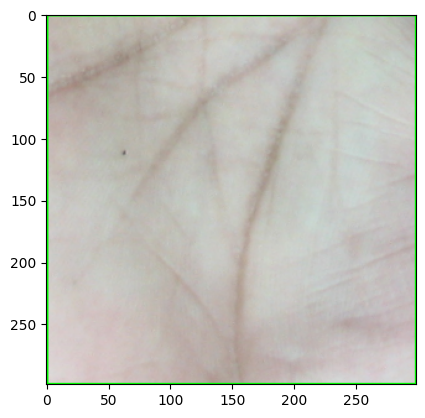

In [9]:
cropped = get_palm_roi(img)
plt.imshow(cropped)

In [10]:
# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".JPG") or filename.endswith(".bmp")  or filename.endswith(".tiff"):
        # Full path to the input image file
        img_path = os.path.join(input_folder, filename)

        # Read the image 
        input_image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if input_image is None:
            print(f"Skipping {filename}: Unable to load image")
            continue

        # Perform image processing 
        print(f"Processing image: {img_path}")
        cropped = get_palm_roi(input_image)
        if cropped is None:
            continue
        processed_image = cv2.resize(cropped, (square_length, square_length))
        colour_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, colour_image)

print("Processing complete.")

Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/005_1.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/121_5.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/040_1.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/164_5.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/066_2.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/142_6.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/023_2.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/107_6.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/220_5.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/018_4.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/206_6.JPG
Processing image: /Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Left Hand/199_5.JPG
Proc